# CNN: Precting Polarization through CNN Text Classification 

I followed a great [guide](https://chriskhanhtran.github.io/posts/cnn-sentence-classification/) about using CNNs for Sentence Classification from **Chris Tran** (huge thanks to this guy!) Also, Ben Trevett has a great [tutorial](https://github.com/bentrevett/pytorch-sentiment-analysis/blob/master/4%20-%20Convolutional%20Sentiment%20Analysis.ipynb) for pytorch-sentiment-analysis using CNNs.

In [1]:
import pandas as pd
import numpy as np
import pre_processing as pp
import torch
import random

In [2]:
if torch.cuda.is_available():       
    device = torch.device("cuda")
    print(f'There are {torch.cuda.device_count()} GPU(s) available.')
    print('Device name:', torch.cuda.get_device_name(0))
    USE_CUDA=True

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")
    USE_CUDA=False

No GPU available, using the CPU instead.


In [3]:
SEED = 30255 # Specify a seed for reproducability

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

## 0. Download Data

In [4]:
tweets = pd.read_csv('data/tweets_all.csv')
tweets = tweets[tweets.text.notnull()]
print(tweets.shape)
tweets.head()

(20697, 9)


,id,topic,source,text,replyCount,vaderMean,vaderStd,vaderCatLabel,vaderCat
0,1377385383168765952,Politics,FoxNews,activists protest renaming chicago school afte...,306,-0.052830,0.445459,medium,1.0
1,1377384607969013765,Violence,FoxNews,border patrol video shows smugglers abandoning...,108,-0.045958,0.495337,medium,1.0
2,1377384339105669122,Media,FoxNews,cause of tiger woods car crash determined but ...,169,-0.034919,0.424833,medium,1.0
3,1377367836046192641,Politics,FoxNews,gop rep urges hhs to halt reported plan to rel...,80,0.043459,0.495874,medium,1.0
4,1377358399759785987,Politics,FoxNews,some democrats trying to stop iowa new hampshi...,96,-0.040135,0.433053,medium,1.0


In [5]:
tweets.vaderCat.unique()

array([1., 0., 2.])

### 0.1 What is the max number of words for a given tweet in the dataset? 
This will be used as the fix length of a sentence in our model 

In [6]:
print('Max number of words for a given tweet in the Dataset:')
max_len = tweets.text.apply(lambda x: len(x.split())).max()
print(max_len)

Max number of words for a given tweet in the Dataset:
53


In [7]:
t= tweets[(tweets.replyCount <=60)].groupby('vaderCatLabel').size()
print(t)
print("observations for filtered data:{}".format(t.sum()))

vaderCatLabel
high      4138
low       5532
medium    6994
dtype: int64
observations for filtered data:16664


### 0.1 What data to use? Filter by topic? By number of replies? Use all?

I proposed to filter by number of replies, as we get a more balanced data with this filter. 

In [8]:
data_to_use = tweets[(tweets.replyCount <=60)]

## 1. Convert to Pytorch Data Objects

### 1.1 Data Class

In [9]:
from dataclassCNN import ProjectDataset

In [10]:
data_obj = ProjectDataset(data_to_use, 'vaderCat', 'text')

## 2. Get Vocabulary and Pre-trained Vectors

### Vocabulary from dataset

In [11]:
from collections import Counter
from torchtext.vocab import Vocab


counter_words = Counter()
for (label, text) in data_obj:
    counter_words.update(text)
    
vocab_words = Vocab(counter_words)

print('The vocabulary length is {} words'.format(len(vocab_words)))

The vocabulary length is 19548 words


### Load Pre-trained vectors (e.g. GloVe or FastText) and get the pre-trained vectors from vocabulary

In [12]:
VECTORS_CACHE_DIR = './.vector_cache'

In [13]:
from torchtext import vocab

fastText = vocab.FastText(language='en',cache=VECTORS_CACHE_DIR)

pre_trained_vectors = fastText.get_vecs_by_tokens(vocab_words.itos)

./.vector_cache/wiki.en.vec: 6.60GB [06:08, 17.9MB/s]                                
100%|██████████| 2519370/2519370 [03:54<00:00, 10755.52it/s]


## 3. Collate Function for CNN Model

We are going to use the pre-trained embeddings and construct a `max_len` (53) long vector of embeddings, adding the `<pad>` word vector to the end for the tweets (sentences) that do not have the full `max_len`. 

In [14]:
def collate_for_cnn(batch, max_len=max_len):
    '''
    For each batch, develop the appropiate inputs from the models (i.e. embeddings)
    '''
    input_vector = []
    labels = []
    for i, (label, tokenized_sent) in enumerate(batch):
        
        #Append labels 
        labels.append(label)
        
        #Get tokenized sentence
        tokenized_sent += ['<pad>'] * (max_len - len(tokenized_sent))
        
        wordstoidx = [vocab_words.stoi[w] for w in tokenized_sent]
        input_vector.append(wordstoidx)
    
    return torch.tensor(labels).to(device), torch.tensor(input_vector).to(device)

## 4. Setting up Train, Validation, Test set and DataLoader Class

In [15]:
from torch.utils.data import DataLoader

In [16]:
from sklearn.model_selection import train_test_split

# Train with Validation Data and Test Data Split
train_val_texts, test_texts, train_val_labels, test_labels = train_test_split(
    data_to_use['text'], data_to_use['vaderCat'], test_size=0.1, random_state=42)

#Train and Validation Split
train_texts, val_texts, train_labels, val_labels = train_test_split(
    train_val_texts, train_val_labels, test_size=0.1, random_state=42)

In [17]:
def data_loader(train_tuple, val_tuple, test_tuple,
                batch_size=30):
    """Convert train, validation and test sets into Dataloaders :)
    """

    # Create DataLoader for training data
    train_data = ProjectDataset(train_tuple)
    train_dataloader = DataLoader(train_data, shuffle=True,
                                  batch_size=batch_size, 
                                 collate_fn=collate_for_cnn)
    
    # Create DataLoader for validation data
    valid_data = ProjectDataset(val_tuple)
    val_dataloader = DataLoader(valid_data, shuffle=False,
                                  batch_size=batch_size, 
                                 collate_fn=collate_for_cnn)

    # Create DataLoader for test data
    test_data = ProjectDataset(test_tuple)
    test_dataloader = DataLoader(test_data, shuffle=False,
                                  batch_size=batch_size, 
                                 collate_fn=collate_for_cnn)

    return train_dataloader, val_dataloader, test_dataloader

In [18]:
train_dataloader, val_dataloader, test_dataloader = data_loader([train_labels, train_texts],
                                                               [val_labels, val_texts],
                                                               [test_labels, test_texts])

In [19]:
for i in train_dataloader:
    labels, inputs = i[0], i[1]
    print(inputs.shape)
    break

torch.Size([30, 53])


## 5. Model Building: CNN Arquitecture

explanation here


In [20]:
FILTER_SIZES = [3,4,5]
N_FILTERS = 100
DROPOUT = 0.5
PAD_IDX = vocab_words.stoi['<pad>']
num_classes = 3 #Low, Medium, High

### 5.1 CNN Model Class

In [21]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CNN_polarization(nn.Module):
    ''' An 1D Convulational Neural Network for Sentence Classification'''
    
    def __init__(self, pretrained_embedding=None, freeze_embedding=False,
                 vocab_size=None, embed_dim=None,
                 filter_sizes=FILTER_SIZES, num_filters=N_FILTERS,
                 num_classes=num_classes,pad_id=PAD_IDX,
                 dropout=DROPOUT):
        """
        pretrained_embedding (torch.Tensor): Pretrained embeddings with
                shape (vocab_size, embed_dim)
            freeze_embedding (bool): Set to False to fine-tune pretraiend
                vectors. Default: False
            vocab_size (int): Need to be specified when not pretrained word
                embeddings are not used.
            embed_dim (int): Dimension of word vectors. Need to be specified
                when pretrained word embeddings are not used. Default: 300
            filter_sizes (List[int]): List of filter sizes. Default: [3, 4, 5]
            num_filters (int): Number of filters. Default: 100
            n_classes (int): Number of classes. Default: 3
            dropout (float): Dropout rate. Default: 0.5
        """

        super(CNN_polarization, self).__init__()
        
        # 1. Embedding layer
        if pretrained_embedding is not None:
            self.vocab_size, self.embed_dim = pretrained_embedding.shape
            self.embedding = nn.Embedding.from_pretrained(pretrained_embedding,
                                                          freeze=freeze_embedding)
        else:
            self.embed_dim = embed_dim
            self.embedding = nn.Embedding(num_embeddings=vocab_size,
                                          embedding_dim=self.embed_dim,
                                          padding_idx= pad_id,
                                          max_norm=5.0)
        
        # 2. Convolutional Layers (for each filter size --> n-gram)
        self.convs = nn.ModuleList([
                                    nn.Conv1d(in_channels = self.embed_dim,
                                              out_channels = num_filters, 
                                              kernel_size = fs)
                                    for fs in filter_sizes
                                    ])
        
    
        # 3. Fully-connected layer
        self.linear = nn.Linear(in_features = len(filter_sizes) * num_filters, 
                                out_features = num_classes
                               )
        
        
        # Additional Feature
        self.dropout = nn.Dropout(dropout)

    def forward(self, inputs):

        x_embedded = self.embedding(inputs)
        
        x_embedded = x_embedded.permute(0, 2, 1)
        
        # Apply CNN and ReLU
        convs_list = [F.relu(conv(x_embedded)) for conv in self.convs]

        # Max pooling.
        pooled = [F.max_pool1d(x_conv, kernel_size=x_conv.shape[2]).squeeze(2)
                  for x_conv in convs_list]
        
        # Concatenate Pool list to feed the fully connected layer
        input_fc = self.dropout(torch.cat(pooled, dim = 1))
        
        # Compute probabilities
        predictions_classes = self.linear(input_fc)
        
        return predictions_classes

### 5.3 Training Function for one epoch

In [22]:

def train_an_epoch(model, dataloader, loss_function, optimizer):
    
    model.train() # Sets the module in training mode.
    total_loss = 0
    
    for idx, batch in enumerate(dataloader):
        
        # Load batch to GPU
        labels, inputs = tuple(t.to(device) for t in batch)
        
        # Zero out any previously calculated gradients
        model.zero_grad()
        
        #Perform a forward pass.
        log_probs = model(inputs)
        
        # Compute loss and accumulate the loss values
        loss = loss_function(log_probs, labels.long())
        total_loss += loss.item()
        
        # Perform a backward pass to calculate gradients
        loss.backward()
        optimizer.step()
    
    return total_loss/len(dataloader)

### 5.4 Evaluate Function

In [23]:
def evaluate(model, dataloader, loss_fn):
    '''
    Evaluate the model on the given data (e.g. validation data or test data).
    '''

    #As we are now using dropout, we must remember to use model.eval() 
    #to ensure the dropout is "turned off" while evaluating.
    model.eval()
    
    total_accuracy = []
    total_loss = []
    
    with torch.no_grad():
        # No gradients need to be maintained during evaluation
        for i, batch in enumerate(dataloader):
            
            # Load batch to Device
            labels, inputs = batch[0], batch[1]
            if USE_CUDA:
                labels, inputs = labels.cuda(), inputs.cuda()
                
            # Obtain probabilities of each class per sentence
            output = model(inputs)
            
            # Compute loss
            loss = loss_fn(output, labels.long())
            total_loss.append(loss.item())
            
            # Get the predictions
            preds = torch.argmax(output, dim=1).flatten()
            
            # Calculate the accuracy rate
            accuracy = (preds == labels).sum()/len(preds)
            total_accuracy.append(accuracy)
            

    return np.mean(total_loss), np.mean(total_accuracy)

### 5.5 Complete Training Function (With early stopping for best model)

In [24]:
import datetime

def train_validate(model, optimizer, train_dataloader, val_dataloader, epochs=20):
    
    """Train the CNN model."""
    
    #Loss function
    loss_function = nn.CrossEntropyLoss()
    
    # Tracking best model
    val_losses = []
    val_accuracies = []
    best_model = None
    
    # Start training loop
    print("Start training...\n")
    print(f"{'Epoch':^7} | {'Time Training(seconds)':^8} | {'Train Loss':^9} |{'Val Loss':^10} | {'Val Acc':^11}")
    print("-"*80)

    for epoch_i in range(epochs):
        start_time = datetime.datetime.now()
        # =======================================
        #               Training
        # =======================================
        
        avg_loss_train = train_an_epoch(model, train_dataloader, loss_function, optimizer)
        
        # =======================================
        #               Evaluation
        # =======================================
        
        val_loss, val_accuracy = evaluate(model, val_dataloader, loss_function)

        # Track the best model
        if len(val_losses) == 0 or val_loss < min(val_losses):
            best_model = type(model)(pretrained_embedding=pre_trained_vectors, filter_sizes=filter_sizes,
                                     num_filters=N_FILTERS, num_classes=num_classes)
            best_model.load_state_dict(model.state_dict())
            if USE_CUDA:
                best_model = best_model.cuda()
        
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)
        
        time_diff = (datetime.datetime.now() - start_time).seconds
        
        print(f"{epoch_i + 1:^7} |   {time_diff:^8}   | {avg_loss_train:^9} | {val_loss:^10} | {val_accuracy:^11}")
        print('')
        
    return best_model, val_accuracies

# 6. Train the model

In [25]:
num_classes = len(tweets.vaderCat.unique())
filter_sizes = [2, 3, 4] # bi-grams, tri-grams, four-grams filters
N_FILTERS = 100

### 6.1 Initialize Model and Optimizer

In [26]:
cnn_model = CNN_polarization(pretrained_embedding=pre_trained_vectors,
                        freeze_embedding=False,
                        filter_sizes=filter_sizes,
                        num_filters=N_FILTERS,
                        num_classes=num_classes,
                        dropout=DROPOUT).to(device)

In [27]:
learning_rate = 0.01
optimizer = torch.optim.Adam(cnn_model.parameters(), 
                                 lr=learning_rate)

In [28]:
best_model, val_accuracies = train_validate(cnn_model, optimizer, 
                                            train_dataloader, val_dataloader, epochs=20)

Start training...

 Epoch  | Time Training(seconds) | Train Loss | Val Loss  |   Val Acc  
--------------------------------------------------------------------------------
   1    |      44      | 1.1807660920090146 | 1.182009608745575 | 0.382666677236557

   2    |      45      | 1.3734942130247751 | 1.3358265769481659 | 0.40799999237060547

   3    |      49      | 1.725801849630144 | 1.666714814901352 | 0.40666666626930237

   4    |      49      | 1.6280672453509437 | 1.6005100071430207 | 0.40733328461647034

   5    |      48      | 1.6306050128406948 | 1.960930370092392 | 0.41466668248176575

   6    |      50      | 1.4926161213715872 | 1.5354959738254548 | 0.40666666626930237

   7    |      50      | 1.274472368425793 | 1.3402659177780152 | 0.4086666405200958

   8    |      50      | 1.2542569149865044 | 1.4853100740909577 | 0.4013333022594452

   9    |      51      | 1.2096691921022202 | 1.325696313381195 | 0.40133339166641235

  10    |      50      | 1.2273320529195997 | 

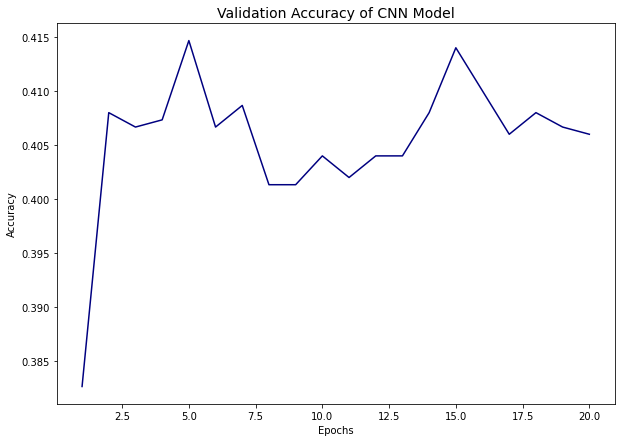

In [32]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=(10,7))
plt.plot(range(1, len(val_accuracies)+1), val_accuracies, color='navy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title('Validation Accuracy of CNN Model', fontsize=14);

## 7. Test the Best Model

In [29]:
#Loss function
loss_function = nn.CrossEntropyLoss()
test_loss, test_accuracy = evaluate(best_model, test_dataloader, loss_function)

In [30]:
test_accuracy

0.4240196

In [31]:
print(':( shit')

:( shit
